# <center>Trabajo Práctico Computacional 1:<br>Conceptos Básicos</center>

Grupo 9: Facundo Joaquı́n Garcı́a, Agustı́n Brusco, Eitan Sprejer

# Punto 1: Redes de interacción de proteínas

In [2]:
# Imports
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib_venn as venn
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

# Variables globales
GIANT_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "width": 0.25, "edge_color": "black"}
MIDLE_FORMAT = {"with_labels" : False,
                "node_size": 8, "node_color": "darkred", "edgecolors": "grey",
                "linewidths": 0.25, "width": 0.25, "edge_color": "grey"}
SMALL_FORMAT = {"with_labels" : False,
                "node_size": 5, "node_color": "firebrick", "edgecolors": "grey",
                "linewidths": 0.25, "width": 0.25, "edge_color": "grey"}


networks = ['AP-MS', 'LIT', 'Y2H']
files = [f'{name}.txt' for name in networks]
try:
    dataframes = [pd.read_csv(f'datasets/{filename}', delimiter="\t",
                            header=None, names=["source", "target"]) for filename in files]
except FileNotFoundError:
    git_folder_url = r'https://raw.githubusercontent.com/facundojgarcia02/CoNet/main/TP1/'
    dataframes = [pd.read_csv(f'{git_folder_url}datasets/{filename}', delimiter="\t",
                            header=None, names=["source", "target"]) for filename in files]
# Cargamos todas las redes como grafos no dirigidos:
graphs = [nx.from_pandas_edgelist(df, create_using=nx.Graph) for df in dataframes]

**Nota:** Se decidió utilizar redes no dirigidas para los tres datasets debido a como se guardaron los datos. Como se puede observar en la siguiente celda, todas los enlaces están ordenados alfabeticamente (dada la interacción entre proteinas $A$ y $B$ en cualquier sentido, se almacenó únicamente el par ordenado $[A, B]$). Esto implica que se perdió toda la información que pudiera haber existido sobre la direccionalidad de la red.

Dicho esto, dadas las metodologías empleadas para obtener los enlaces de las redes "LIT" y "AP-MS" podemos suponer que no existe una direccionalidad real en la interacción mapeada. Sin embargo, no podemos decir lo mismo de las interacciones obtenidas de los métodos Yeast Two-Hybrid.

In [3]:
for net, df in zip(networks, dataframes):
    df_test = df.copy()
    
    # Tiramos los autoenlaces
    idx = [i for i in range(len(df)) if df.loc[i, "source"] != df.loc[i, "target"]]
    df = df.loc[idx]
    
    # Revisamos cuales están ordenados alfabéticamente
    ordered = np.sum([(df["source"].iloc[i] < df["target"].iloc[i]) for i in range(len(df))])
    print("-"*60 + f"\n{net}:")
    print(f"\tCantidad de enlaces: {len(df)}")
    print(f"\tCantidad de enlaces ordenados alfabéticamente: {ordered}")

------------------------------------------------------------
AP-MS:
	Cantidad de enlaces: 9070
	Cantidad de enlaces ordenados alfabéticamente: 9070
------------------------------------------------------------
LIT:
	Cantidad de enlaces: 2844
	Cantidad de enlaces ordenados alfabéticamente: 2844
------------------------------------------------------------
Y2H:
	Cantidad de enlaces: 2705
	Cantidad de enlaces ordenados alfabéticamente: 2705


## a) Comparación gráfica

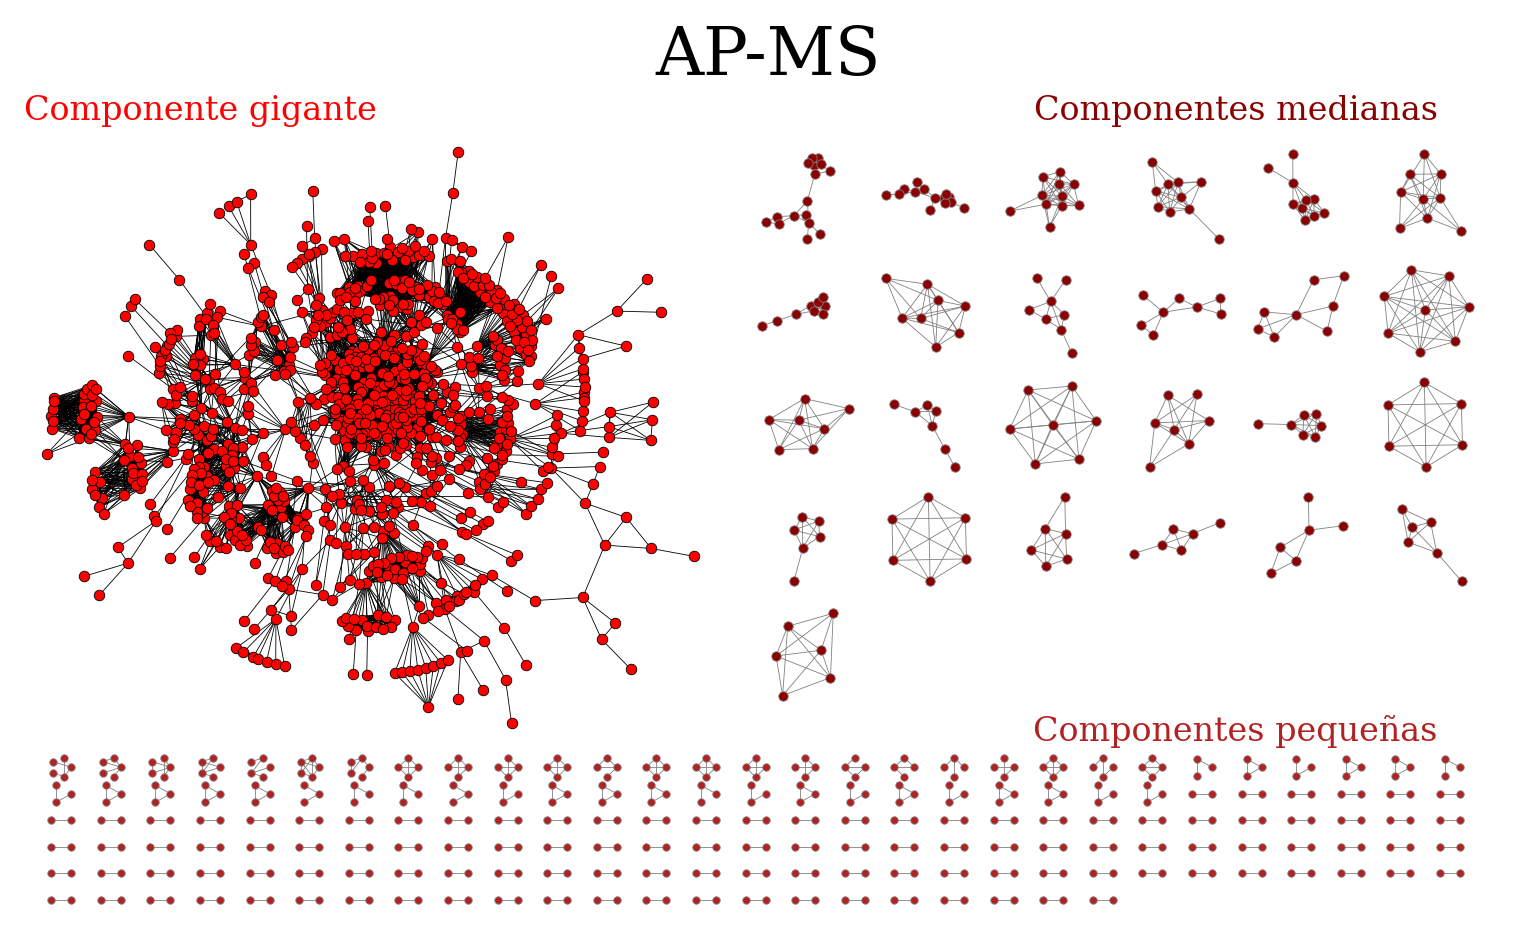

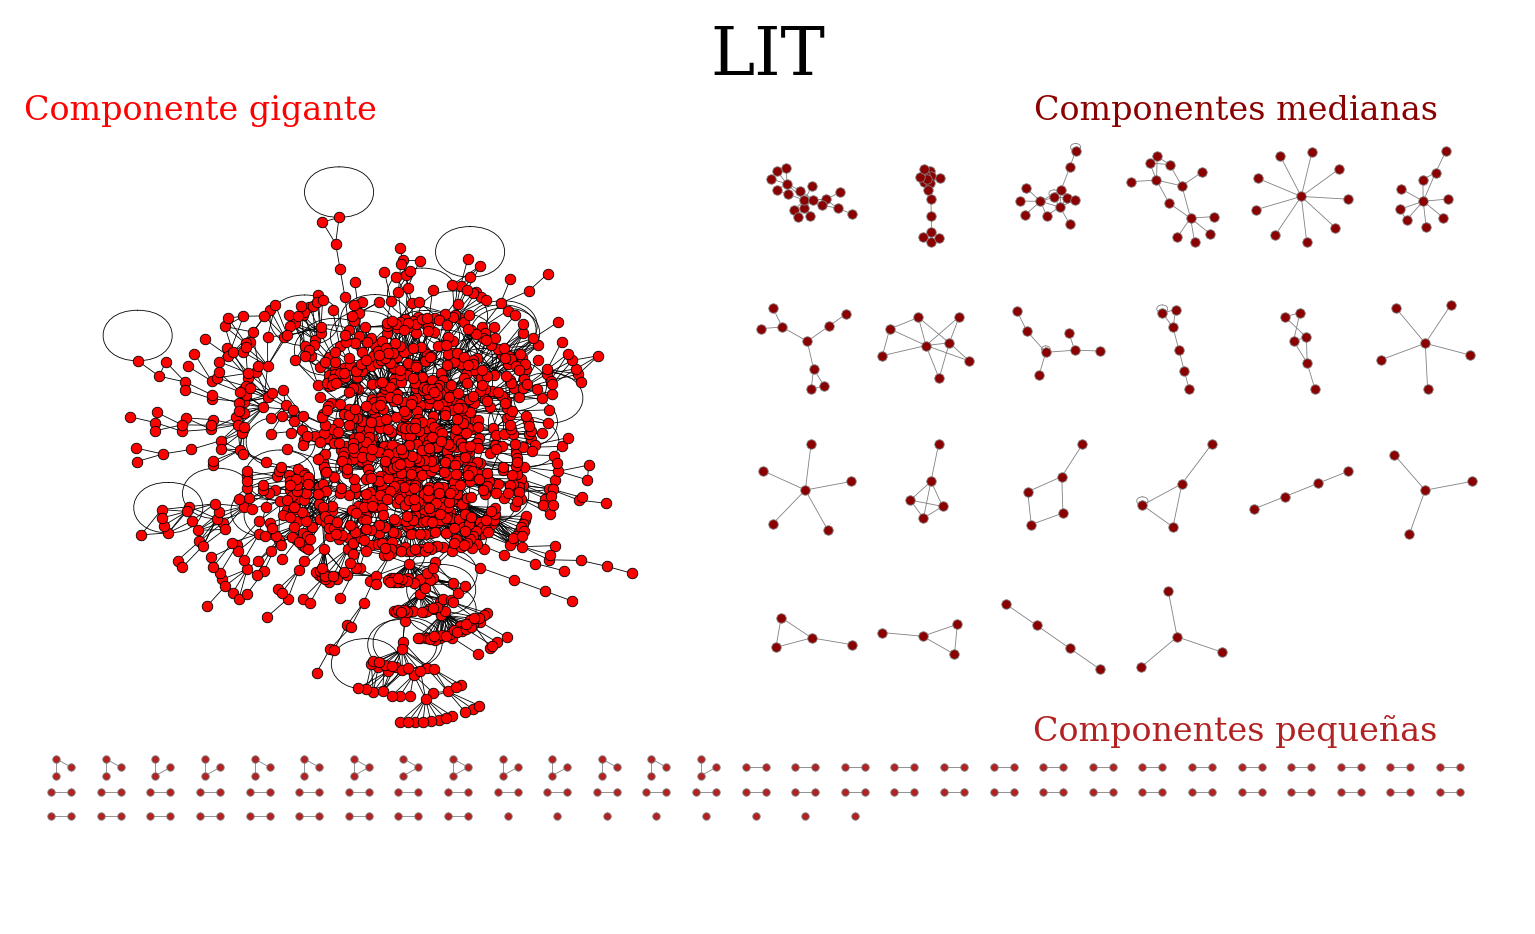

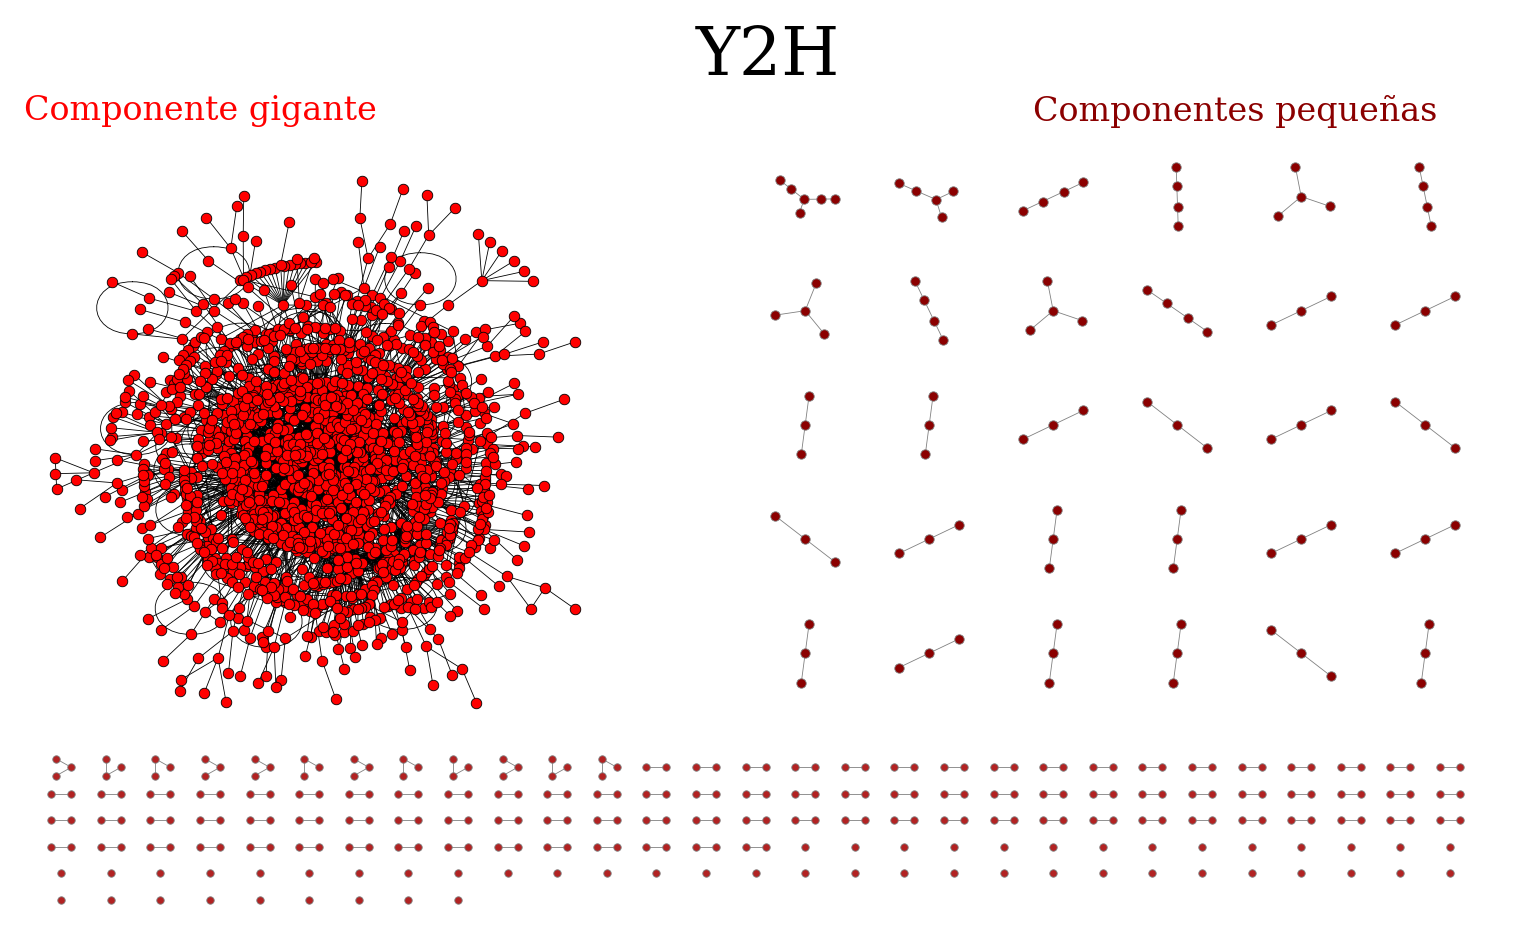

In [4]:
# Lista de diccionarios con los parámetros utilizados para graficar las redes
params = [ # AMPS
          {"graph": graphs[0], "cut_size": 5, "title": "AP-MS",
           
           "giant_off": [9/4, 12/2], "giant_scale": 0.5,
           
           "med_off": [5.25, 8.75], "med_sep": [5/6, 7/5], "med_scale": 0.065, 
           "med_title": True, "med_text": "Componentes medianas",
           
           "small_off": [0.25, 1.75], "small_sep": [1/2, 1.3/4],
           "small_title": True, "small_text": 'Componentes pequeñas',},
          
          # LIT
          {"graph": graphs[1], "cut_size": 3, "title": "LIT",
           
           "giant_off": [5/2, 11/2], "giant_scale": 0.4,
           
           "med_off": [5.25, 8.75], "med_sep": [5/6, 9/5], "med_scale": 0.07, 
           "med_title": True, "med_text": "Componentes medianas",
           
           "small_off": [0.25, 1.75], "small_sep": [1/2, 1.2/4],
           "small_title": True, "small_text": 'Componentes pequeñas',},
          
          # Y2H
          {"graph": graphs[2], "cut_size": 2, "title": "Y2H",
           
           "giant_off": [4/2, 11/2], "giant_scale": 0.43,
           
           "med_off": [5.25, 8.75], "med_sep": [5/6, 7/5], "med_scale": 0.045, 
           "med_title": True, "med_text": "Componentes pequeñas",
           
           "small_off": [0.25, 1.75], "small_sep": [1/2, 1.3/4],
           "small_title": False, "small_text": 'Componentes pequeñas',}
         ]

for p in params:
    # Extracción de las componentes de la red:
    net_components = [p["graph"].subgraph(c).copy() for c in sorted(nx.connected_components(p["graph"]),
                                                                    key=len, reverse=True)]
    
    # Inicialización del gráfico:
    scale_arr = np.array([9, 16])/2
    fig = plt.figure(figsize=tuple(scale_arr[::-1]))

    ### Gráfico de la componente gigante:
    #------------------------------------
    plt.text(0, 10, 'Componente gigante', va='top', c=GIANT_FORMAT["node_color"])
    layout_giant = nx.layout.kamada_kawai_layout(net_components[0])
    main_layout = {k: v*scale_arr*p["giant_scale"] + np.array(p["giant_off"]) for k, v in layout_giant.items()}
    nx.draw(net_components[0], pos=main_layout, **GIANT_FORMAT)

    ### Gráfico de las demas componentes:
    #------------------------------------
    
    # A la derecha las más grandes
    if p["med_title"]: plt.text(9.5, 10, p["med_text"], va='top', ha='right', c=MIDLE_FORMAT["node_color"])
    x0, y0 = p["med_off"]  
    x1, y1 = x0, y0
    x_sep, y_sep = p["med_sep"]
    off = np.array([x0, y0])
    for i, comp in enumerate(net_components[1:], start=1):
        if y1 < 2 or len(comp) <= p["cut_size"]:
            break
        l = nx.spring_layout(comp, seed=42)
        moved_l = {k: v*scale_arr*p["med_scale"] + off for k, v in l.items()}
        nx.draw(comp, pos=moved_l, **MIDLE_FORMAT)
        if x1 + x_sep >= 10:
            y1 -= y_sep
            x1 = x0
            off = np.array([x0, y1])
        else:
            x1 += x_sep
            off = np.array([x1, y1])
    
    # Abajo las más pequeñas
    if p["small_title"]: plt.text(9.5, 2, p["small_text"], va='bottom', ha='right', c=SMALL_FORMAT["node_color"])
    x0, y0 = p["small_off"]  
    x1, y1 = x0, y0
    x_sep, y_sep = p["small_sep"]
    off = np.array([x0, y0])
    for j, comp in enumerate(net_components[i:], start=i):
        l = nx.circular_layout(comp)
        moved_l = {k: v*scale_arr*1.5e-2 + off for k, v in l.items()}
        nx.draw(comp, pos=moved_l, **SMALL_FORMAT)
        if x1 + x_sep >= 10:
            y1 -= y_sep
            x1 = x0
            off = np.array([x0, y1])
        else:
            x1 += 2*x_sep/3
            off = np.array([x1, y1])
    
    # Seteo de las dimensiones para la correcta visualización
    plt.xlim(0, 10)
    plt.ylim(0, 10)

    plt.title(p["title"], fontsize=20)
    
    plt.show()

**Nota:** Para mantener la generalidad del código se tomó la decisión de representar con diferentes tamaños a componentes con la misma cantidad de nodos. Por ejemplo: en "Y2H" se grafican con mayor tamaño componentes de 3 nodos que en "LIT"; o en "LIT" se etiquetan como "componentes medianas" a redes de 4 nodos, que en "AP-MS" fueron consideradas "componentes pequeñas".

Lo importante es utilizar los diferentes gráficos para comparar visualmente las diferencias entre las componentes gigantes de cada red, y obtener rápidamente una noción del tamaño y cantidad de las otras componentes que existen en cada caso.

## b) Tabla de características

In [6]:
attrs = {}
# Construimos el dict de valores para cada red:
for net, graph in zip(networks, graphs):
    attr = {}
    attr['Numero de nodos'] = len(graph.nodes)
    attr['Numero de enlaces'] = len(graph.edges)
    attr['Es dirigida?'] = False  # Justificación en celdas 3 y 4.
    degrees = list(dict(graph.degree).values())
    attr['Grado medio'] = round(np.mean(degrees), 4)
    attr['Grado mínimo'] = np.min(degrees)
    attr['Grado máximo'] = np.max(degrees)
    attr['Densidad'] = round(2*attr['Numero de enlaces']/(attr['Numero de nodos']*(attr['Numero de nodos']-1)), 4)
    attr['Coeficiente de Clustering medio'] = round(nx.average_clustering(graph, count_zeros=True), 4)
    attr['Coeficiente de Clustering global'] = round(nx.transitivity(graph), 4)
    components = nx.connected_components(graph)
    diams = [nx.diameter(graph.subgraph(comp).copy()) for comp in components]
    attr['Diámetro'] = max(diams)
    attrs[net] = attr

pd.DataFrame(attrs).T

,Numero de nodos,Numero de enlaces,Es dirigida?,Grado medio,Grado mínimo,Grado máximo,Densidad,Coeficiente de Clustering medio,Coeficiente de Clustering global,Diámetro
AP-MS,1622,9070,False,11.1837,1,127,0.0069,0.5546,0.6186,15
LIT,1536,2925,False,3.8086,1,40,0.0025,0.2925,0.3462,19
Y2H,2018,2930,False,2.9039,1,91,0.0014,0.0462,0.0236,14


## c) Análisis de resultados

Para el dataset AP-MS, se obtienen valores mas altos de número de enlaces, grado medio y máximo y coeficientes de clustering medio y global. Creemos que esto puede ser explicado por la metodología utilizada para analizar la interacción entre proteinas, ya que se hacen interactuar muchas proteinas entre sí en un mismo experimento.

Se puede apreciar que el coeficiente de clustering medio y global de "Y2H" es menor que en "LIT", a pesar de tener la misma cantidad de enlaces. Esto se puede deber a que "Y2H" cuenta con más nodos. El hecho de que contengan la misma cantidad de enlaces puede deberse a la metodología empleada para obtener el dataset de "LIT", en la que resulta muy probable que hayan sobre-estimado el número de enlaces al conectar proteinas en base a una interpretación automatizada de relaciones en texto en vez de en los resultados directos de experimentación.

## d) Diagramas de Venn

In [7]:
nodes_apms = pd.concat([dataframes[0]["source"], dataframes[0]["target"]]).unique() # 0 : APMS
nodes_lit  = pd.concat([dataframes[1]["source"], dataframes[1]["target"]]).unique() # 1 : LIT
nodes_y2h  = pd.concat([dataframes[2]["source"], dataframes[2]["target"]]).unique() # 2 : Y2H

edges_apms = [tuple(sorted(i)) for i in graphs[0].edges]
edges_lit  = [tuple(sorted(i)) for i in graphs[1].edges]
edges_y2h  = [tuple(sorted(i)) for i in graphs[2].edges]

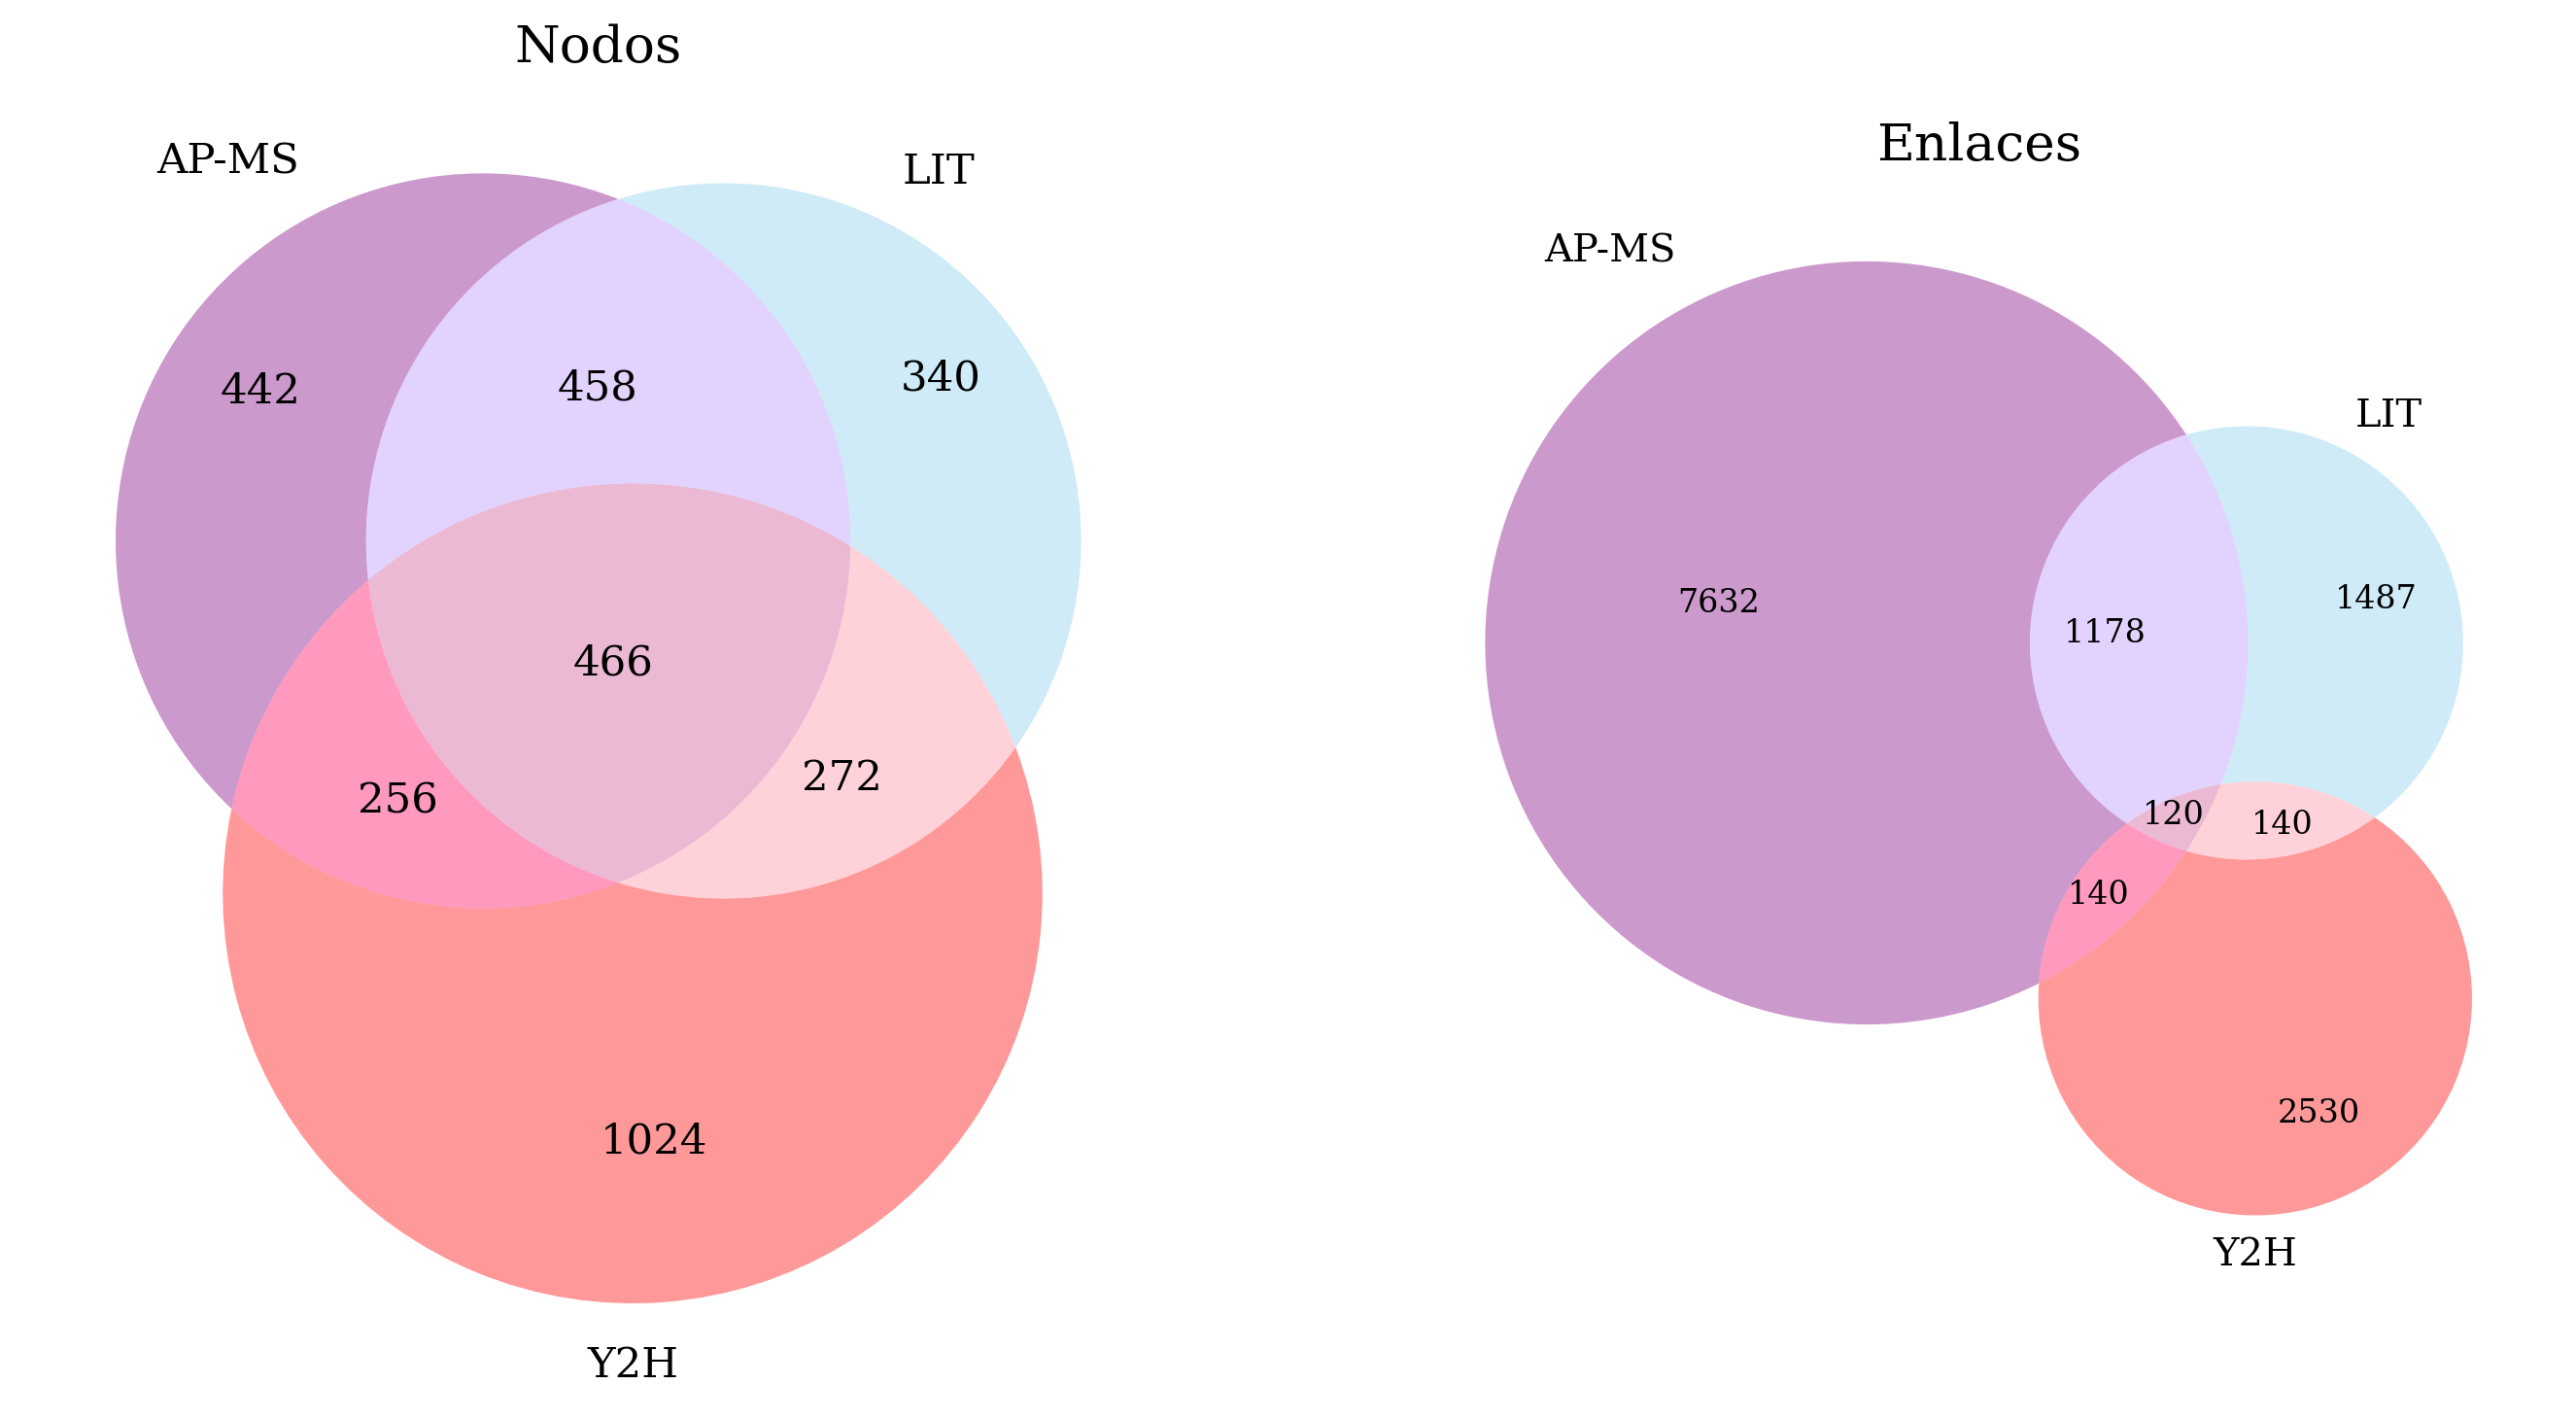

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (14, 10))
fig.set_facecolor("white")

v_nodes = venn.venn3([set(nodes_apms), set(nodes_lit), set(nodes_y2h)], set_labels = ('AP-MS', 'LIT', 'Y2H'),
          set_colors =("Purple", "Skyblue", "Red"), ax = ax[0])

v_edges = venn.venn3([set(edges_apms), set(edges_lit), set(edges_y2h)], set_labels = ('AP-MS', 'LIT', 'Y2H'),
          set_colors =("Purple", "Skyblue", "Red"), ax = ax[1])

for text in ax[0].texts:
    text.set_fontsize(13)

ax[0].set_title("Nodos", fontsize = 16)
ax[1].set_title("Enlaces", fontsize = 16)

plt.show()